# Spatial Graph Neural Network (Spatial GNN)

Prediction of the intention of pedestrians to cross the street or not, using Graph Neural Networks and the coordinates of their skeleton that was previously generated using Openpose in the JAAD dataset.

**Input:** Pedestrian skeleton graph.

**Output:** Binary classification (crossing or not crossing the street).

In [ ]:
import numpy as np

from torch import from_numpy
from torch import cuda
from torch import no_grad
from torch import optim

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

import matplotlib.pyplot as plt

import pandas as pd

%matplotlib inline

from Code.GNN import *
from Code.SkeletonsDataset import *
from Code.ModelTrainEvaluate import *
from Code.MetricsPlots import *

# Dataset

## Training dataset

In [2]:
train_dataset = SkeletonsDataset('Data/train_annotations_with_skeletons.csv', normalization='minmax', target='cross')

print('train_dataset len:', len(train_dataset))
print('Shape of each skeletons data (x):', train_dataset.data[0].x.shape)

train_dataset.loadedData

train_dataset len: 38813
Shape of each skeletons data (x): torch.Size([25, 3])


,video,id,frame,occluded,outside,x2,y2,x1,y1,age,...,pose_front,pose_left,pose_right,stroller_cart,sunglasses,umbrella,speed,video_path,skeleton,skeleton_detected
0,video_0001,0_1_2b,0,0,0,1486.0,892.0,1398.0,654.0,adult,...,1.0,0.0,0.0,0.0,0.0,0.0,moving_slow,/datatmp/Datasets/intention_prediction/JAAD/vi...,"[[1448.57, 674.503, 0.924437], [1442.74, 698.0...",True
1,video_0001,0_1_2b,1,0,0,1490.0,894.0,1402.0,655.0,adult,...,1.0,0.0,0.0,0.0,0.0,0.0,moving_slow,/datatmp/Datasets/intention_prediction/JAAD/vi...,"[[1451.47, 674.493, 0.906491], [1445.66, 698.0...",True
2,video_0001,0_1_2b,2,0,0,1493.0,897.0,1406.0,656.0,adult,...,1.0,0.0,0.0,0.0,0.0,0.0,moving_slow,/datatmp/Datasets/intention_prediction/JAAD/vi...,"[[1451.58, 674.604, 0.856983], [1448.49, 698.0...",True
3,video_0001,0_1_2b,3,0,0,1496.0,899.0,1409.0,657.0,adult,...,1.0,0.0,0.0,0.0,0.0,0.0,moving_slow,/datatmp/Datasets/intention_prediction/JAAD/vi...,"[[1457.41, 677.444, 0.82119], [1448.66, 698.11...",True
4,video_0001,0_1_2b,4,0,0,1499.0,901.0,1413.0,658.0,adult,...,1.0,0.0,0.0,0.0,0.0,0.0,moving_slow,/datatmp/Datasets/intention_prediction/JAAD/vi...,"[[1466.12, 677.516, 0.846119], [1451.56, 700.9...",True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44967,video_0278,0_278_2189b,115,0,0,1135.0,868.0,1029.0,642.0,adult,...,0.0,0.0,1.0,0.0,0.0,0.0,decelerating,/datatmp/Datasets/intention_prediction/JAAD/vi...,"[[0.0, 0.0, 0.0], [1074.76, 691.992, 0.916943]...",True
44968,video_0278,0_278_2189b,116,0,0,1151.0,874.0,1044.0,643.0,adult,...,0.0,0.0,1.0,0.0,0.0,0.0,decelerating,/datatmp/Datasets/intention_prediction/JAAD/vi...,"[[0.0, 0.0, 0.0], [1095.41, 692.256, 0.973779]...",True
44969,video_0278,0_278_2189b,117,0,0,1167.0,880.0,1058.0,643.0,adult,...,0.0,0.0,1.0,0.0,0.0,0.0,decelerating,/datatmp/Datasets/intention_prediction/JAAD/vi...,"[[0.0, 0.0, 0.0], [1115.94, 692.05, 0.955257],...",True
44970,video_0278,0_278_2189b,118,0,0,1183.0,886.0,1073.0,644.0,adult,...,0.0,0.0,1.0,0.0,0.0,0.0,decelerating,/datatmp/Datasets/intention_prediction/JAAD/vi...,"[[1160.16, 671.633, 0.0615215], [1127.72, 694....",True


Important columns:

In [3]:
train_dataset.loadedData[['video','frame','decision_point','skeleton','skeleton_detected','cross','crossing']]

,video,frame,decision_point,skeleton,skeleton_detected,cross,crossing
0,video_0001,0,26,"[[1448.57, 674.503, 0.924437], [1442.74, 698.0...",True,not-crossing,-1
1,video_0001,1,26,"[[1451.47, 674.493, 0.906491], [1445.66, 698.0...",True,not-crossing,-1
2,video_0001,2,26,"[[1451.58, 674.604, 0.856983], [1448.49, 698.0...",True,not-crossing,-1
3,video_0001,3,26,"[[1457.41, 677.444, 0.82119], [1448.66, 698.11...",True,not-crossing,-1
4,video_0001,4,26,"[[1466.12, 677.516, 0.846119], [1451.56, 700.9...",True,not-crossing,-1
...,...,...,...,...,...,...,...
44967,video_0278,115,-1,"[[0.0, 0.0, 0.0], [1074.76, 691.992, 0.916943]...",True,crossing,1
44968,video_0278,116,-1,"[[0.0, 0.0, 0.0], [1095.41, 692.256, 0.973779]...",True,crossing,1
44969,video_0278,117,-1,"[[0.0, 0.0, 0.0], [1115.94, 692.05, 0.955257],...",True,crossing,1
44970,video_0278,118,-1,"[[1160.16, 671.633, 0.0615215], [1127.72, 694....",True,crossing,1


Number of elements per class:

Training dataset total rows: 38813
Training dataset crossing class samples: 21584
Training dataset not-crossing class samples: 17229


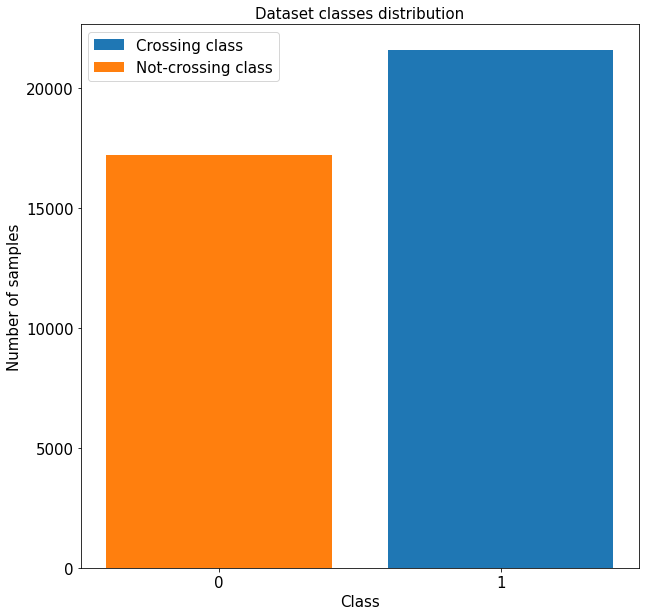

In [4]:
totalRows = len(train_dataset.loadedData)
crossingRows = len(train_dataset.loadedData[train_dataset.loadedData['cross']=='crossing'])
nocrossingRows = len(train_dataset.loadedData[train_dataset.loadedData['cross']=='not-crossing'])

print('Training dataset total rows:', totalRows)
print('Training dataset crossing class samples:', crossingRows)
print('Training dataset not-crossing class samples:', nocrossingRows)

plt.figure(figsize=(10,10))
plt.bar(1, crossingRows, label='Crossing class')
plt.bar(0, nocrossingRows, label='Not-crossing class')
plt.legend(loc='upper left', prop={'size': 15})
plt.xticks([0, 1], size=15)
plt.yticks(size=15)
plt.xlabel('Class', size=15)
plt.ylabel('Number of samples', size=15)
plt.title('Dataset classes distribution', size=15)
plt.show()

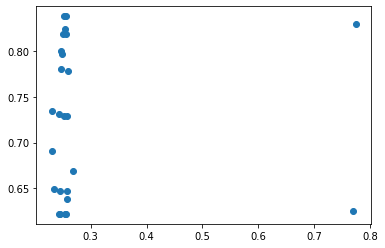

In [5]:
skeleton = train_dataset.data[10].x[:, 0:2].tolist()

skeleton2 = []

for sk in skeleton:
    if(sk!=[0, 0]):
        skeleton2.append(sk)
        
skeleton2 = np.asarray(skeleton2)

plt.figure()
plt.scatter(skeleton2[:, 0], skeleton2[:, 1])
plt.show()

## Validation dataset

In [6]:
val_dataset = SkeletonsDataset('Data/val_annotations_with_skeletons.csv', normalization='minmax',
                               norm_precomputed_values = [train_dataset.xmax, train_dataset.xmin], target='cross')
                               # norm_precomputed_values = [train_dataset.xmean, train_dataset.xstd]

val_dataset.shuffle()

In [7]:
print('val_dataset len:', len(val_dataset))
print('Shape of each skeletons data (x):', val_dataset.data[0].x.shape)

val_dataset.loadedData

val_dataset len: 4223
Shape of each skeletons data (x): torch.Size([25, 3])


,video,id,frame,occluded,outside,x2,y2,x1,y1,age,...,pose_left,pose_right,stroller_cart,sunglasses,umbrella,speed,video_path,skeleton,skeleton_detected,outputs
0,video_0280,0_280_2201b,0,0,0,641.0,846.0,618.0,772.0,adult,...,0,1,0,0,0,moving_fast,/datatmp/Datasets/intention_prediction/JAAD/vi...,"[[627.482, 621.559, 0.257434], [627.388, 645.0...",True,"[[631.0001220703125, 622.58251953125], [629.85..."
65,video_0280,0_280_2201b,65,0,0,640.0,882.0,569.0,763.0,adult,...,0,1,0,0,0,decelerating,/datatmp/Datasets/intention_prediction/JAAD/vi...,"[[577.243, 621.402, 0.379725], [600.817, 636.2...",True,"[[617.3148803710938, 615.83544921875], [616.56..."
66,video_0280,0_280_2201b,66,0,0,640.0,883.0,571.0,764.0,adult,...,0,1,0,0,0,decelerating,/datatmp/Datasets/intention_prediction/JAAD/vi...,"[[577.273, 618.514, 0.335216], [594.962, 630.3...",True,"[[588.305419921875, 612.5685424804688], [587.1..."
67,video_0280,0_280_2201b,67,0,0,640.0,883.0,572.0,765.0,adult,...,0,1,0,0,0,decelerating,/datatmp/Datasets/intention_prediction/JAAD/vi...,"[[577.232, 621.44, 0.422622], [580.398, 647.9,...",True,"[[587.4631958007812, 628.0204467773438], [585...."
68,video_0280,0_280_2201b,68,0,0,640.0,884.0,574.0,766.0,adult,...,0,1,0,0,0,decelerating,/datatmp/Datasets/intention_prediction/JAAD/vi...,"[[577.335, 621.406, 0.615219], [577.496, 645.0...",True,"[[577.976318359375, 622.7041625976562], [576.8..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5267,video_0312,0_312_2449b,115,0,0,458.0,983.0,278.0,623.0,senior,...,1,0,0,0,0,accelerating,/datatmp/Datasets/intention_prediction/JAAD/vi...,"[[318.347, 671.511, 0.894349], [362.597, 692.0...",True,"[[372.368408203125, 659.8908081054688], [369.7..."
5268,video_0312,0_312_2449b,116,0,0,441.0,992.0,252.0,622.0,senior,...,1,0,0,0,0,accelerating,/datatmp/Datasets/intention_prediction/JAAD/vi...,"[[291.928, 671.461, 0.706857], [338.893, 689.2...",True,"[[350.1001892089844, 637.2662963867188], [345...."
5269,video_0312,0_312_2449b,117,0,0,424.0,1000.0,226.0,620.0,senior,...,1,0,0,0,0,accelerating,/datatmp/Datasets/intention_prediction/JAAD/vi...,"[[262.442, 665.701, 0.726526], [300.784, 689.1...",True,"[[317.420654296875, 643.6817626953125], [312.8..."
5270,video_0312,0_312_2449b,118,0,0,396.0,1015.0,201.0,619.0,senior,...,1,0,0,0,0,accelerating,/datatmp/Datasets/intention_prediction/JAAD/vi...,"[[224.293, 668.62, 0.874003], [274.165, 689.24...",True,"[[283.4302978515625, 642.0805053710938], [280...."


Important columns:

In [8]:
val_dataset.loadedData[['video','frame','decision_point','skeleton','skeleton_detected','cross','crossing']]

,video,frame,decision_point,skeleton,skeleton_detected,cross,crossing
0,video_0280,0,33,"[[627.482, 621.559, 0.257434], [627.388, 645.0...",True,not-crossing,1
65,video_0280,65,33,"[[577.243, 621.402, 0.379725], [600.817, 636.2...",True,crossing,1
66,video_0280,66,33,"[[577.273, 618.514, 0.335216], [594.962, 630.3...",True,crossing,1
67,video_0280,67,33,"[[577.232, 621.44, 0.422622], [580.398, 647.9,...",True,crossing,1
68,video_0280,68,33,"[[577.335, 621.406, 0.615219], [577.496, 645.0...",True,crossing,1
...,...,...,...,...,...,...,...
5267,video_0312,115,-1,"[[318.347, 671.511, 0.894349], [362.597, 692.0...",True,crossing,1
5268,video_0312,116,-1,"[[291.928, 671.461, 0.706857], [338.893, 689.2...",True,crossing,1
5269,video_0312,117,-1,"[[262.442, 665.701, 0.726526], [300.784, 689.1...",True,crossing,1
5270,video_0312,118,-1,"[[224.293, 668.62, 0.874003], [274.165, 689.24...",True,crossing,1


Number of elements per class:

Validation dataset total rows: 4223
Validation dataset crossing class samples: 1510
Validation dataset not-crossing class samples: 2713


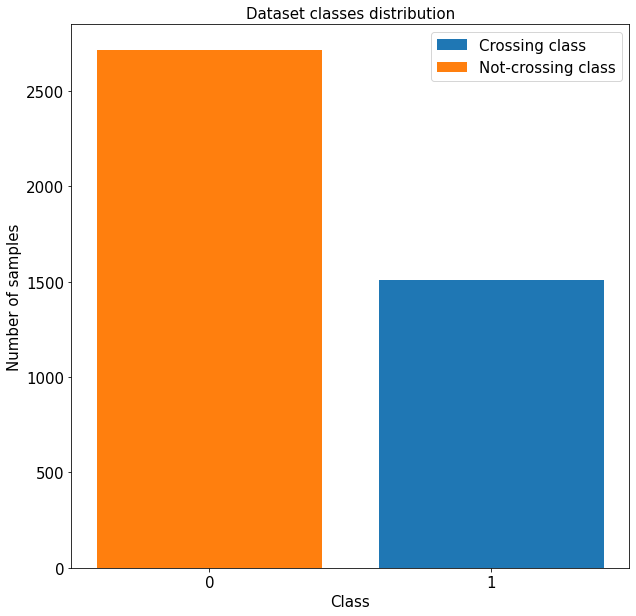

In [9]:
totalRows = len(val_dataset.loadedData)
crossingRows = len(val_dataset.loadedData[val_dataset.loadedData['cross']=='crossing'])
nocrossingRows = len(val_dataset.loadedData[val_dataset.loadedData['cross']=='not-crossing'])

print('Validation dataset total rows:', totalRows)
print('Validation dataset crossing class samples:', crossingRows)
print('Validation dataset not-crossing class samples:', nocrossingRows)

plt.figure(figsize=(10,10))
plt.bar(1, crossingRows, label='Crossing class')
plt.bar(0, nocrossingRows, label='Not-crossing class')
plt.legend(loc='best', prop={'size': 15})
plt.xticks([0, 1], size=15)
plt.yticks(size=15)
plt.xlabel('Class', size=15)
plt.ylabel('Number of samples', size=15)
plt.title('Dataset classes distribution', size=15)
plt.show()

Since the classes of the two datasets are unbalanced, we cannot rely only on accuracy as our metric.

## Showing a skeleton

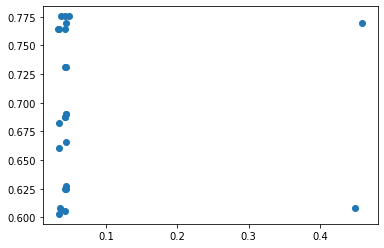

In [10]:
skeleton = val_dataset.data[10].x[:, 0:2].tolist()

skeleton2 = []

for sk in skeleton:
    if(sk!=[0, 0]):
        skeleton2.append(sk)
        
skeleton2 = np.asarray(skeleton2)

plt.figure()
plt.scatter(skeleton2[:, 0], skeleton2[:, 1])
plt.show()

# Training

In [11]:
numberOfClasses = 2

y = train_dataset.loadedData['cross'].to_numpy()
y = np.where(y=='crossing', 1, 0)
bc = np.bincount(y)

class_weights = len(train_dataset.loadedData) / (numberOfClasses * bc)
class_weights = torch.tensor(class_weights, dtype=torch.float)

print('class_weights:', class_weights)

class_weights: tensor([1.1264, 0.8991])


In [12]:
train_dataset.shuffle()
test_dataset = train_dataset[:5000]
train_dataset = train_dataset[5000:]

len(train_dataset), len(val_dataset), len(test_dataset)

(33813, 4223, 5000)

In [13]:
# First element of training subset:
t0 = train_dataset[0]

# Node features:
t1 = t0.x

# Number of nodes:
numberOfNodes = t1.shape[0]

# Number of dimensions of each node features:
embed_dim = t1.shape[1]

print('Number of nodes per skeleton:', numberOfNodes)
print('Number of features per node:', embed_dim)

Number of nodes per skeleton: 25
Number of features per node: 3


In [14]:
num_epochs = 25
batch_size = 50

device = torch.device('cpu')
model = SpatialGNN(embed_dim, numberOfClasses, numberOfNodes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
crit = torch.nn.BCELoss()#weight=class_weights)

train_loader = DataLoader(train_dataset, batch_size=batch_size)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

loss_values = []

metrics_train = []
metrics_val = []

for epoch in range(num_epochs):

    train_loss = train(model, train_loader, device, optimizer, crit)
    loss_values.append(train_loss)

    train_metrics = evaluate(model, train_loader, device, computed_loss=train_loss)
    val_metrics = evaluate(model, val_loader, device, loss_crit=crit)

    metrics_train.append(train_metrics)
    metrics_val.append(val_metrics)
    
    if num_epochs <= 25:
        
        print_evaluation_train_val(epoch, train_metrics, val_metrics)

Epoch:                           001
Train Loss:                   0.6483  -  Validation Loss:                   0.6351
Train Accuracy:               0.6802  -  Validation Accuracy:               0.5792
Train Balanced accuracy:      0.6686  -  Validation Balanced accuracy:      0.6314
Train Precision:              0.6885  -  Validation Precision:              0.4510
Train Recall:                 0.7739  -  Validation Recall:                 0.8146
Train f1-score:               0.7288  -  Validation f1-score:               0.5806
 


Epoch:                           002
Train Loss:                   0.6133  -  Validation Loss:                   0.6214
Train Accuracy:               0.6928  -  Validation Accuracy:               0.6178
Train Balanced accuracy:      0.6857  -  Validation Balanced accuracy:      0.6487
Train Precision:              0.7117  -  Validation Precision:              0.4782
Train Recall:                 0.7506  -  Validation Recall:                 0.7570
Train f1-

Epoch:                           017
Train Loss:                   0.5814  -  Validation Loss:                   0.5908
Train Accuracy:               0.7018  -  Validation Accuracy:               0.6619
Train Balanced accuracy:      0.7048  -  Validation Balanced accuracy:      0.6680
Train Precision:              0.7592  -  Validation Precision:              0.5205
Train Recall:                 0.6777  -  Validation Recall:                 0.6894
Train f1-score:               0.7161  -  Validation f1-score:               0.5932
 


Epoch:                           018
Train Loss:                   0.5814  -  Validation Loss:                   0.5971
Train Accuracy:               0.7063  -  Validation Accuracy:               0.6538
Train Balanced accuracy:      0.7071  -  Validation Balanced accuracy:      0.6639
Train Precision:              0.7536  -  Validation Precision:              0.5116
Train Recall:                 0.6995  -  Validation Recall:                 0.6993
Train f1-

## Model performance plots

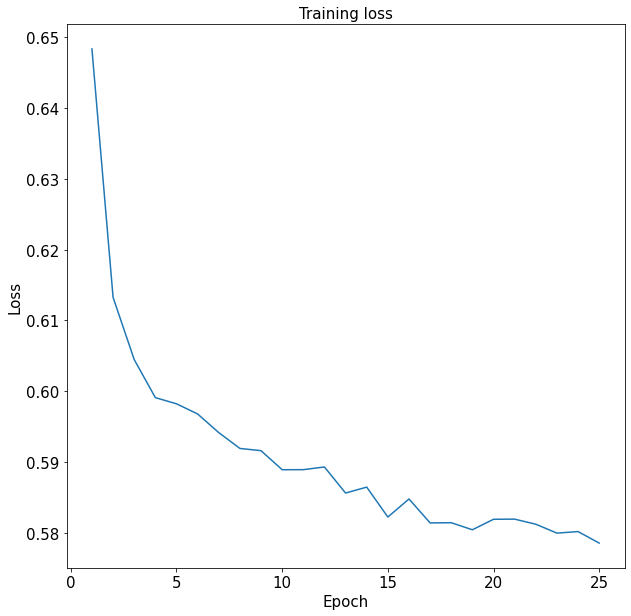

In [15]:
plot_loss(num_epochs, loss_values, figsize=10, textsize=15)

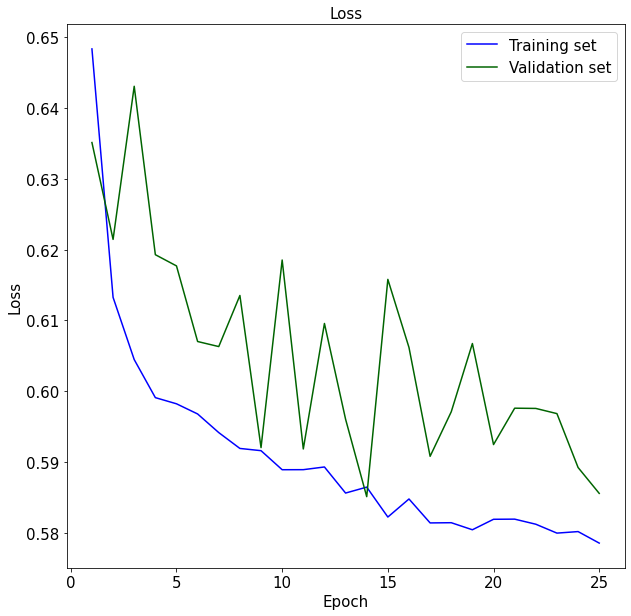

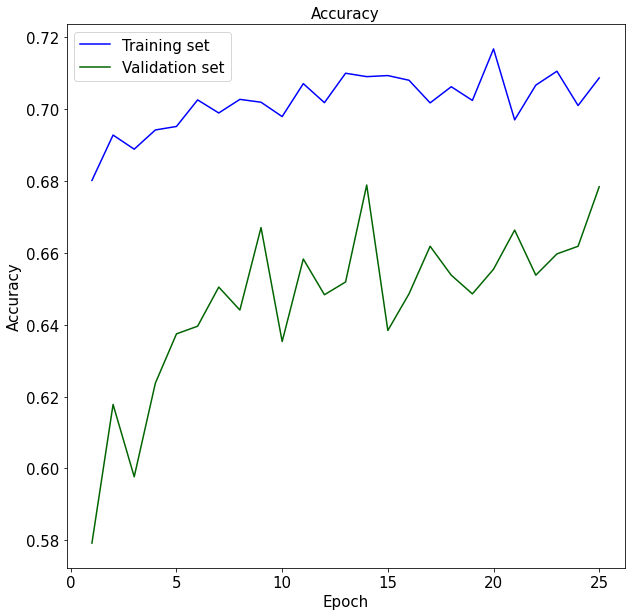

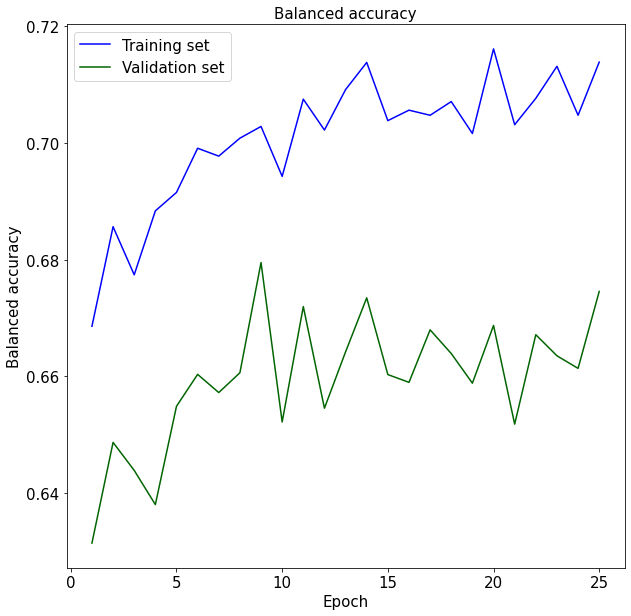

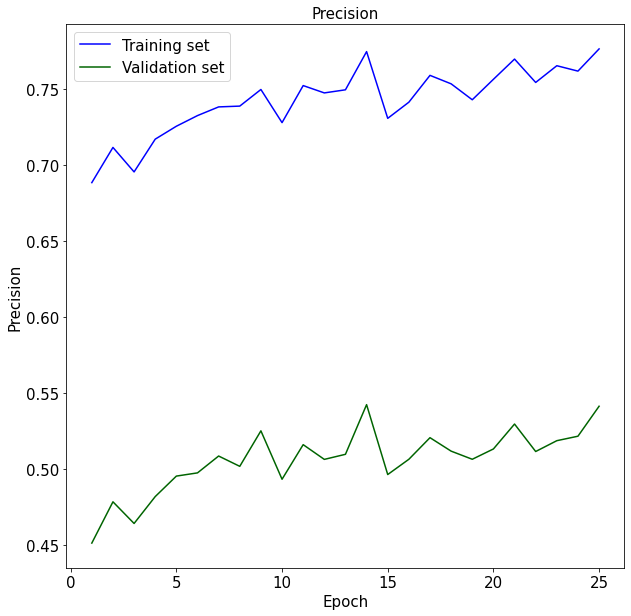

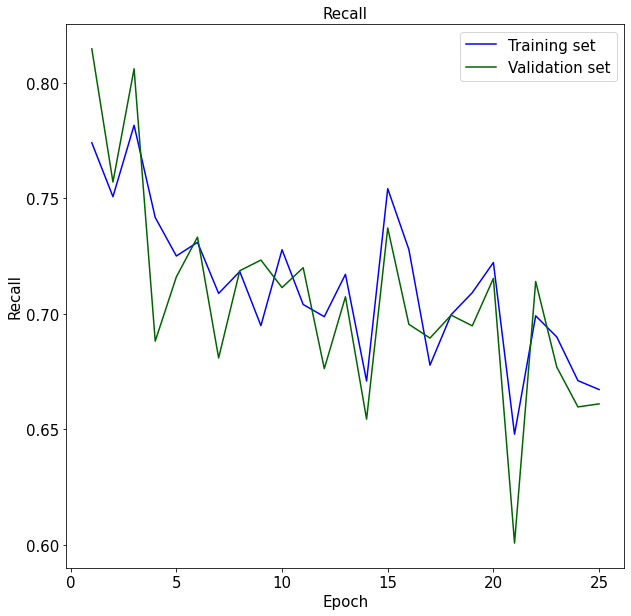

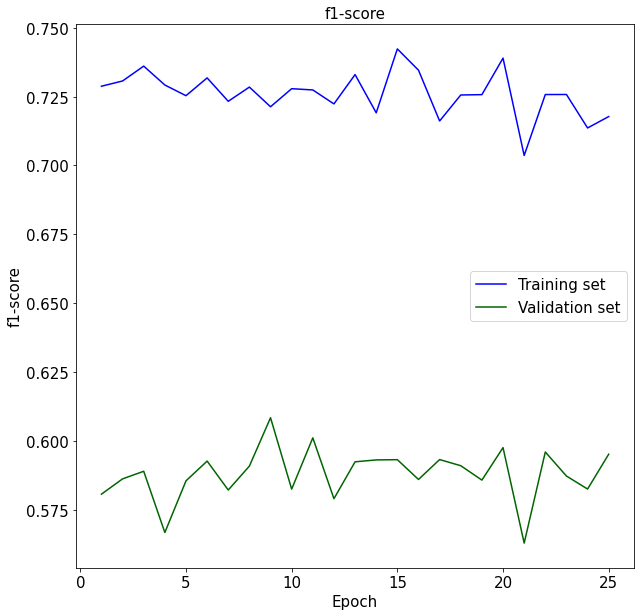

In [16]:
plot_classification_metrics_train_val(num_epochs, metrics_train, metrics_val, figsize=10, textsize=15)

## ROC curves

### Train set

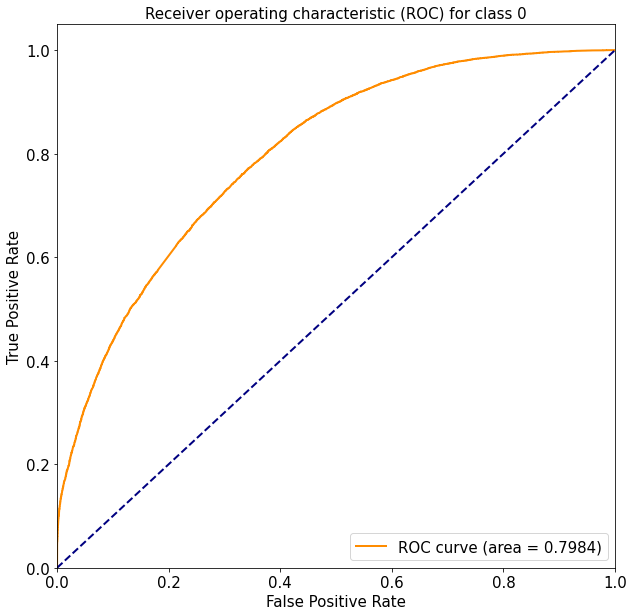

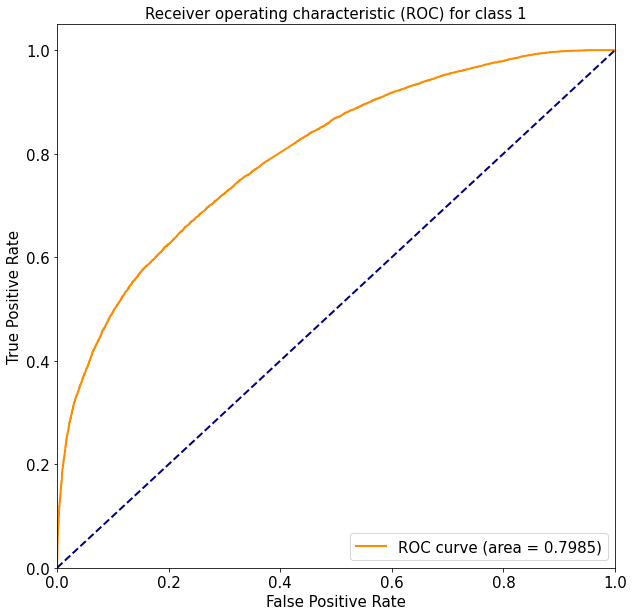

In [17]:
fpr, tpr, roc_auc = ROC(model, train_loader, device, numberOfClasses)

for plotclass in range(0, numberOfClasses):
    plot_ROC(plotclass, fpr, tpr, roc_auc)

### Validation set

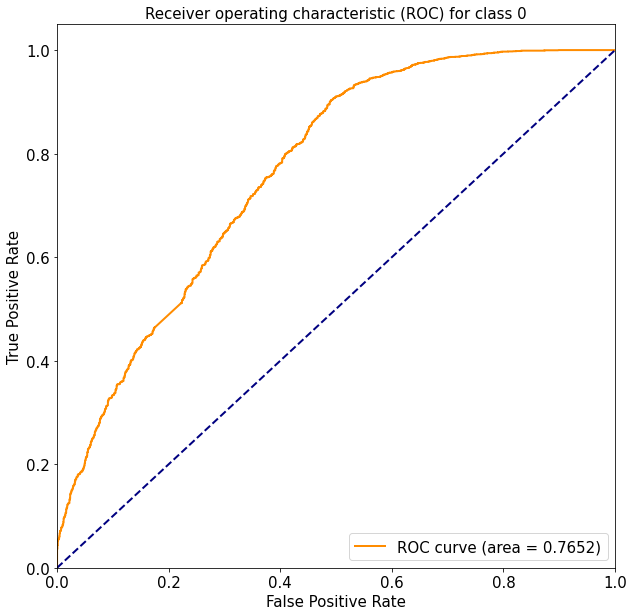

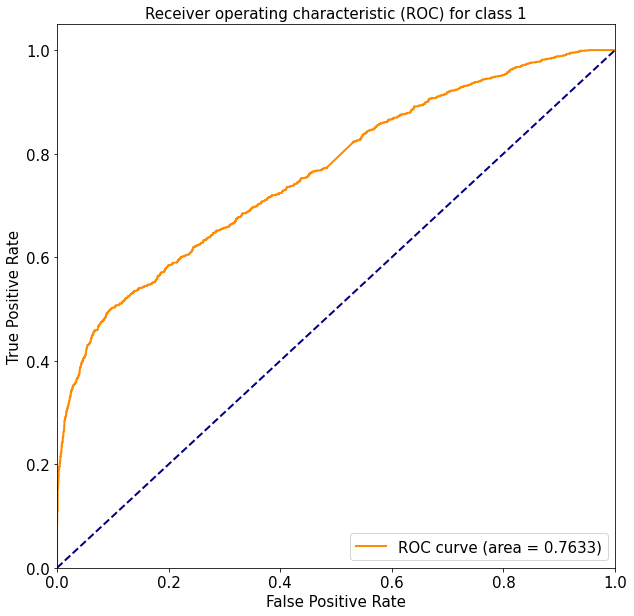

In [18]:
fpr, tpr, roc_auc = ROC(model, val_loader, device, numberOfClasses)

for plotclass in range(0, numberOfClasses):
    plot_ROC(plotclass, fpr, tpr, roc_auc)

# Testing

In [19]:
test_loader = DataLoader(test_dataset, batch_size=batch_size)
test_metrics = evaluate(model, test_loader, device)


print_evaluation_test(test_metrics)

Testing subset results:

Accuracy:                 0.6970
Balanced accuracy:        0.7035
Precision:                0.7742
Recall:                   0.6517
f1-score:                 0.7077
 


